# Lab 2 - AiSec: HỌC LIÊN KẾT (FEDERATE LEARNING) VÀ BẢO MẬT TẠI SERVER
[link text](https://)
| MSSV     | Họ tên         | Email             |
|----------|----------------|-------------------|
| 21120022 | Cao Quảng Phát    | 21120022@student.hcmus.edu.vn |
| 21120074 | Tạ Công Hoàng      | 21120074@student.hcmus.edu.vn  |


In [37]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

lab_folder = '/content/drive/MyDrive/Đại học/Học kỳ 7/AiSec/Lab2'
model_folder = os.path.join(lab_folder, 'model')
data_folder = os.path.join(lab_folder, 'data')
extracted_features_dir =  os.path.join(lab_folder, "extracted_features")

os.makedirs(model_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)
os.makedirs(extracted_features_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

# #cd to lab_folder variable
%cd $lab_folder

code_folder = './code'
data_folder = './data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Đại học/Học kỳ 7/AiSec/Lab2


In [23]:
lab_folder = './'
code_folder = './code'
data_folder = './data'
model_folder = './model'
extracted_features_dir = './extracted_features'

In [24]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

###### Train
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim

#####
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score



Global Variable

In [25]:
batch_size = 32
pCV = 0.1

## Requirement 1: Read data and show image and labels of CIFAR-10

### Download Data and Know about Dataset

In [26]:
trainset = torchvision.datasets.CIFAR10(root=data_folder, train=True, download=True)
testset = torchvision.datasets.CIFAR10(root=data_folder, train=False, download=True)
# labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
nClasses  = 10

print('length of training set: ' + str(len(trainset)))
print('length of test set: ' + str(len(testset)))
print(str(trainset))
print("row[0] of dataset: ", trainset[0])

Files already downloaded and verified
Files already downloaded and verified
length of training set: 50000
length of test set: 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
row[0] of dataset:  (<PIL.Image.Image image mode=RGB size=32x32 at 0x15C586540>, 6)


this is an image of a frog


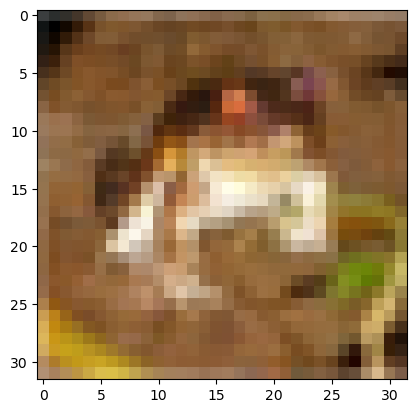

In [27]:
image, label = trainset[0] #since each element of the trainset list is itself a tuple with the image details, and then the label
print("this is an image of a " + classes[label]) # first index into tuple in trainset, then the 2nd value (label), and then the classes
plt.imshow(image)

### Transform image to matrix of color value

In [28]:
def transform_data(data):
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
  data = [(transform(image), label) for image, label in data]
  return data

trainsetT = transform_data(trainset)
testsetT = transform_data(testset)
print("row[0] of trainTransform is tuple with: ", trainsetT[0][0].shape, ",", trainsetT[0][1])

row[0] of trainTransform is tuple with:  torch.Size([3, 32, 32]) , 6


### Split to Train and Valid dataset

In [29]:
def splitIndices(m, pCV):
  """ randomly shuffle a training set's indices, then split the indices into training and cross validation sets.
   Pass in 'm', length of training set, and 'pCV', the percentage of the training set you would like
   to dedicate to cross validation."""

  mCV = int(m*pCV)
  indices = np.random.permutation(m)
  return indices[mCV:], indices[:mCV]

def prepare_data(client_data, pCV = 0.1):
    indices = list(range(len(client_data)))
    trainIndices, valIndices = splitIndices(len(client_data), pCV)

    trainSampler = SubsetRandomSampler(indices)
    trainLoader = DataLoader(client_data, batch_size=batch_size, sampler=trainSampler, drop_last=True)

    validSampler = SubsetRandomSampler(valIndices)
    validLoader = DataLoader(client_data, batch_size=batch_size, sampler=validSampler, drop_last=True)
    return trainLoader, validLoader

trainLoader, validLoader = prepare_data(trainsetT, pCV)
testLoader = DataLoader(testsetT, batch_size=batch_size, drop_last=True)

print(f"train with {len(trainLoader)} batchs")

train with 1562 batchs


### Train with Pytorch

#### CIFAR Customize Model

In [30]:
defaultInputSize = 3 * 32 * 32
defaultOutputSize = 10  # Number of classes

import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10(nn.Module):
    def __init__(self, inputSize=defaultInputSize, numClasses=defaultOutputSize):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)
        self.layers = [
            lambda xb: xb.reshape(-1, self.linear.in_features), # flatten the input
            # self.normalize,
            self.linear,
        ]

    def parameters(self):
        return self.linear.parameters()

    def normalize(self, xb):
        mean = xb.mean(dim=0, keepdim=True)
        std = xb.std(dim=0, keepdim=True)
        return (xb - mean) / std

    def forward(self, xb):
        val = xb
        for layer in self.layers:
            val = layer(val)
        return val

    def state_dict(self):
        return self.linear.state_dict()

    def load_state_dict(self, state_dict):
        self.linear.load_state_dict(state_dict)

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")

    def predict(self, xb):
        output = self.forward(xb)
        probs = F.softmax(output, dim=1)
        maxProbs, preds = torch.max(probs, dim = 1)
        return preds

    @property
    def weight(self):
        return self.linear.weight

    @property
    def bias(self):
        return self.linear.bias

    @property
    def full_param(self):
        return self.linear.weight + self.linear.bias.unsqueeze(1)


#### LossBatch, Evaluate and Fit function

In [31]:
lossFn = F.cross_entropy

def lossBatch(model, lossFn, xb, yb, opt=None, metric=None):
  preds = model(xb)
  loss = lossFn(preds, yb)

  if opt is not None:
    loss.backward()
    # update parameters
    opt.step()
    # reset gradients to 0 (don't want to calculate second derivatives!)
    opt.zero_grad()

  metricResult = None
  if metric is not None:
    metricResult = metric(preds, yb)

  return loss.item(), len(xb),  metricResult

def evaluate(model, lossFn, validDL, metric=None):
  results = [lossBatch(model, lossFn, xb, yb, metric=metric,) for xb,yb in validDL]

  losses, nums, metrics = zip(*results)

  total = np.sum(nums)  # size of the dataset

  avgLoss = np.sum(np.multiply(losses, nums))/total

  # if there is a metric passed, compute the average metric
  if metric is not None:
    avgMetric = np.sum(np.multiply(metrics, nums)) / total

  return avgLoss, total, avgMetric

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1) # underscore discards the max value itself, we don't care about that
  return torch.sum(preds == labels).item() / len(preds)

def fit(epochs, model, lossFn, opt, trainDL, valDL, metric=None, patience=5):
  best_val_loss = float('inf')
  best_weights = model.state_dict()
  patience_counter = 0

  valList = [0.10]
  for epoch in range(epochs):
    # training - perform one step gradient descent on each batch, then moves on
    for xb, yb in trainDL:
      loss, _, lossMetric = lossBatch(model, lossFn, xb, yb, opt)

    with torch.no_grad():  # Disable gradient calculation for validation
        valResult = evaluate(model, lossFn, valDL, metric)
        valLoss, total, valMetric = valResult
        valList.append(valMetric)

    # Check if the current epoch's validation loss is the best
    if valLoss < best_val_loss:
        best_val_loss = valLoss
        best_weights = model.state_dict()  # Save the best model weights
        patience_counter = 0  # Reset the patience counter
    else:
        patience_counter += 1  # Increment patience counter if no improvement

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        model.load_state_dict(best_weights)  # Load the best weights
        break

    # print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, valLoss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch + 1, epochs, valLoss, metric.__name__, valMetric))

  model.load_state_dict(best_weights)
  return valList


def evaluate_with_dataset(model, datasetT, name="Data"):
    X, y = zip(*datasetT)
    X = np.array(X)
    y = np.array(y)

    y_pred = model.predict(torch.tensor(X, dtype=torch.float32))
    print(f"{name} accuracy: %.3f" % accuracy_score(y, y_pred))
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.show()

#### Training Process

In [32]:
#Prepare Data
# trainLoader, validLoader = prepare_data(trainsetT, pCV)
# testLoader = DataLoader(testsetT, batch_size=batch_size, drop_last=True)

model = CIFAR10()
epochs = 100
learningRate = 0.001
opt = torch.optim.SGD(model.parameters(), lr=learningRate)
metric = accuracy

fit(epochs, model, lossFn, opt, trainLoader, validLoader, metric=metric)

Epoch [1/100], Loss: 1.8593, accuracy: 0.3656
Epoch [2/100], Loss: 1.8153, accuracy: 0.3820
Epoch [3/100], Loss: 1.7905, accuracy: 0.3868
Epoch [4/100], Loss: 1.7759, accuracy: 0.3934
Epoch [5/100], Loss: 1.7635, accuracy: 0.4042
Epoch [6/100], Loss: 1.7530, accuracy: 0.4075
Epoch [7/100], Loss: 1.7468, accuracy: 0.4073
Epoch [8/100], Loss: 1.7385, accuracy: 0.4038
Epoch [9/100], Loss: 1.7339, accuracy: 0.4060
Epoch [10/100], Loss: 1.7269, accuracy: 0.4153
Epoch [11/100], Loss: 1.7211, accuracy: 0.4135
Epoch [12/100], Loss: 1.7152, accuracy: 0.4195
Epoch [13/100], Loss: 1.7115, accuracy: 0.4207
Epoch [14/100], Loss: 1.7092, accuracy: 0.4209
Epoch [15/100], Loss: 1.7037, accuracy: 0.4205
Epoch [16/100], Loss: 1.7031, accuracy: 0.4219
Epoch [17/100], Loss: 1.7019, accuracy: 0.4243
Epoch [18/100], Loss: 1.6947, accuracy: 0.4289
Epoch [19/100], Loss: 1.6931, accuracy: 0.4245
Epoch [20/100], Loss: 1.6899, accuracy: 0.4285
Epoch [21/100], Loss: 1.6877, accuracy: 0.4321
Epoch [22/100], Loss: 

[0.1,
 0.3655849358974359,
 0.38201121794871795,
 0.38681891025641024,
 0.39342948717948717,
 0.4042467948717949,
 0.4074519230769231,
 0.4072516025641026,
 0.40384615384615385,
 0.40604967948717946,
 0.4152644230769231,
 0.41346153846153844,
 0.41947115384615385,
 0.4206730769230769,
 0.4208733974358974,
 0.4204727564102564,
 0.421875,
 0.42427884615384615,
 0.42888621794871795,
 0.4244791666666667,
 0.4284855769230769,
 0.43209134615384615,
 0.4308894230769231,
 0.43309294871794873,
 0.4344951923076923,
 0.43529647435897434,
 0.43770032051282054,
 0.43509615384615385,
 0.43409455128205127,
 0.4433092948717949,
 0.4423076923076923,
 0.4387019230769231,
 0.43930288461538464,
 0.4437099358974359,
 0.43810096153846156,
 0.43770032051282054,
 0.4443108974358974,
 0.4411057692307692,
 0.4401041666666667,
 0.44350961538461536,
 0.4385016025641026,
 0.44471153846153844,
 0.4473157051282051,
 0.43970352564102566,
 0.44551282051282054,
 0.44350961538461536,
 0.4479166666666667,
 0.448317307692

### Evaluate with Test Data

Test Evaluate, Loss: 1.7087482714500182, accuracy: 0.4160657051282051
Test set accuracy: 0.416


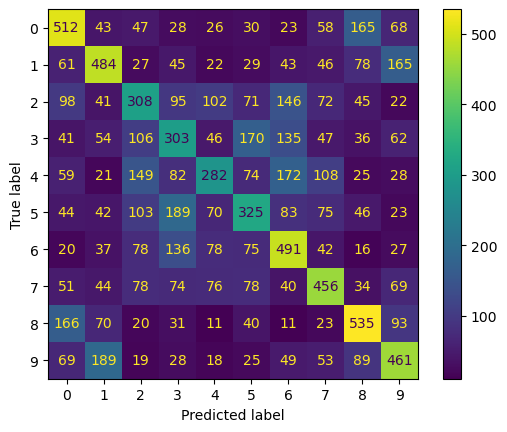

In [33]:
loss, _, acc = evaluate(model, lossFn, testLoader, metric=accuracy)
print(f"Test Evaluate, Loss: {loss}, accuracy: {acc}")
evaluate_with_dataset(model, testsetT, 'Test set')

Test Evaluate, Loss: 1.61886639517187, accuracy: 0.4536651728553137
Test set accuracy: 0.454


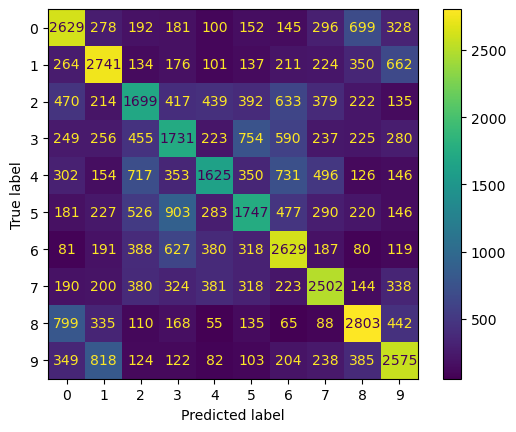

In [34]:
loss, _, acc = evaluate(model, lossFn, trainLoader, metric=accuracy)
print(f"Test Evaluate, Loss: {loss}, accuracy: {acc}")
evaluate_with_dataset(model, trainsetT, 'Test set')

Fully Training Flow

In [35]:
# Flow with plain data
def training_flow(client_data):
  if not isinstance(client_data[0], torch.Tensor):
    client_data = transform_data(client_data)

  trainLoader, validLoader = prepare_data(client_data, pCV)
  model = CIFAR10()
  learningRate = 0.001
  epochs = 10
  opt = torch.optim.SGD(model.parameters(), lr=learningRate)
  metric = accuracy

  fit(epochs, model, lossFn, opt, trainLoader, validLoader, metric=metric)
  return model

## Requirement 2: Federated Learning

### DataSplitting Class
- Support for spliting train dataset to each client.
- Then support for read dataset for each client.

In [36]:
import os
import json
import numpy as np
import torch
from torchvision import datasets, transforms
from typing import Dict, List
import random
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
class DataSplitting:
    def __init__(self, data_dir: str, data_split_file: str, report_file: str = None, data_extract_file: str = None):
        self.data_dir = data_dir
        self.data_split_file = data_split_file
        self.report_file = report_file
        self.data_extract_file = data_extract_file

        self.train_data = None
        self.clients = None

        self._load_data()
        self._load_data_split()
        self._load_report()
        self._load_data_extract_file()

    def _load_data(self):
        self.train_data = datasets.CIFAR10(root=self.data_dir, train=True, download=True)

    def _load_data_split(self):
        with open(self.data_split_file, 'r') as f:
            self.data_split = json.load(f)

        print(f"Data split configuration:")
        for idx, val in enumerate(self.data_split['clients']):
            name, data = val['name'], val['data']
            print(f"Client {idx + 1}: {name} - {data}")

        self.clients_name = [val['name'] for idx, val in enumerate(self.data_split['clients'])]

        label_clientname_list = []
        for label in range(len(self.train_data.classes)):
            clientname_lists = [val['name'] for idx, val in enumerate(self.data_split['clients']) if label in val['data']]
            label_clientname_list.append(clientname_lists)
        self.data_split['label_clientname_list'] = label_clientname_list

    def _load_report(self):
        if self.report_file == None:
            return
        with open(self.report_file, 'r') as f:
            report = json.load(f)
        self.clients = report['clients']
        print(f"Report loaded successfully from {self.report_file}")
        return report

    def _load_data_extract_file(self):
        if self.data_extract_file == None:
            return None
        self.train_features = np.load(self.data_extract_file, allow_pickle=True)
        # cast to float32
        self.train_features = self.train_features.astype('float32')
        print(f"Load training data features from {self.data_extract_file}")
        return self.train_features

    def load_report(self, report_file: str):
        with open(report_file, 'r') as f:
            report = json.load(f)
        self.clients = report['clients']
        print(f"Report loaded successfully from {report_file}")
        return report
    def load_data_extract_file(self, data_extract_file: str):
        self.data_extract_file = data_extract_file
        return self._load_data_extract_file()

    def get_clients_names(self):
        return self.clients_name

    def create_clients(self, unique_data: bool = True):
        """
        Splits the data for each client based on the JSON configuration.

        args:
            - unique_data: If True, all clients get different data.
                            If False, clients can share the same data.
            - self.class_data: The training data with each class label.
            - self.data_split: The configuration for data splitting.
                - n_clients: The number of clients.
                - client_format: The format for client names.
                - class_clients_list: A list of clients for each class.

        return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        """
        n_clients = self.data_split["n_clients"]
        client_format = self.data_split["client_format"]['name']

        # Clear previous client data
        self.clients = {f"{client_format}{i + 1}": [] for i in range(n_clients)}
        if unique_data:
            self._seperate_data_unique(self.train_data, self.clients)
        else:
            self._seperate_data_non_unique(self.train_data, self.clients)

        print(f"Data split successfully for {n_clients} clients.")
        self.generate_report()
        return self.clients

    def _seperate_data_unique(self, train_data, clients):
        """
        Seperates the data for each client uniquely.

        args:
            - clients: A dictionary containing the clients and their data.

        return: A dictionary containing the clients and their data.
        """
        label_clientname_list = self.data_split['label_clientname_list']
        for idx, (image, label) in enumerate(train_data):
            client_names_list = label_clientname_list[label]
            if len(client_names_list) == 0:
                continue
            client_name = random.choice(client_names_list)
            self.clients[client_name].append(idx)
        return self.clients
    def _seperate_data_non_unique(self, train_data, clients):
        """
        Seperates the data for each client non-uniquely.

        args:
            - clients: A dictionary containing the clients and their data.

        return: A dictionary containing the clients and their data.
        """
        label_clientname_list = self.data_split['label_clientname_list']
        for idx, (image, label) in enumerate(train_data):
            client_names_list = label_clientname_list[label]
            for client_name in client_names_list:
                is_choose = random.choice([True, False])
                if is_choose:
                    self.clients[client_name].append(idx)
        return self.clients


    def _save_client_data_to_file(self):
        for client_name, data_indices in self.clients.items():
            print(f"Saving data for client: {client_name}")
            client_folder = os.path.join(self.data_dir, client_name)
            if not os.path.exists(client_folder):
                os.makedirs(client_folder)
            else:
                # Clear previous data
                for file_name in os.listdir(client_folder):
                    os.remove(os.path.join(client_folder, file_name))

            for idx in data_indices:
                image, label = self.train_data[idx]
                image.save(os.path.join(client_folder, f"{idx}_{label}.PNG"))

        print("Client data saved successfully.")


    def generate_report(self) -> Dict:
        """
        Generates a report of the data distribution for each client.

        :return: A dictionary containing the number of samples for each client.
        """
        report = {client_name: {} for client_name in self.clients.keys()}
        for client_name, data_indices in self.clients.items():
            report[client_name]['num_data'] = len(data_indices)
            for label, class_name in enumerate(self.train_data.classes):
                report[client_name][class_name] = sum([1 for idx in data_indices if self.train_data.targets[idx] == label])

        report['clients'] = self.clients
        with open(os.path.join(self.data_dir, 'data_split_report.json'), 'w') as f:
            json.dump(report, f, indent=4)
        print(f"Data split report generated successfully to file {os.path.join(self.data_dir, 'data_split_report.json')}")
        return report

    def get_client_data(self, client_name: str) -> List[tuple]:
        """
        Retrieves the dataset for a specific client.

        :param client_name: The name of the client.
        :return: A subset of the training data corresponding to the client's data.
        """
        if self.clients == None or client_name not in self.clients:
            return self.load_client_data(client_name)
        else:
            print(f"Get data for client: {client_name}")
            client_data = [self.train_data[idx] for idx in self.clients[client_name]]
            return client_data
    def load_client_data_ids_labels(self, client_name: str):
        """
        Retrieves the dataset for a specific client from the saved files.

        :param client_name: The name of the client.
        :return: A subset of the training data corresponding to the client's data.
        """
        client_folder = os.path.join(self.data_dir, client_name)
        print(f"Loading data_id for client: {client_name} at {client_folder}")
        idxs = []
        labels = []
        for file_name in os.listdir(client_folder):
            idx = int(file_name.split('_')[0])
            label = int(file_name.split('_')[-1].split('.')[0])
            idxs.append(idx)
            labels.append(label)
        self.clients[client_name] = idxs
        return idxs, labels
    def load_client_data(self, client_name: str):
        """
        Retrieves the dataset for a specific client from the saved files.

        :param client_name: The name of the client.
        :return: A subset of the training data corresponding to the client's data.
        """
        client_folder = os.path.join(self.data_dir, client_name)
        print(f"Loading data for client: {client_name} at {client_folder}")
        client_data = []
        self.clients[client_name] = []
        for file_name in os.listdir(client_folder):
            # parse image to PIL.Image.Image format
            image = Image.open(os.path.join(client_folder, file_name))
            image = image.convert('RGB')

            idx = int(file_name.split('_')[0])
            label = int(file_name.split('_')[-1].split('.')[0])
            self.clients[client_name].append(idx)
            client_data.append((image, label))
        return client_data

    def get_clients_data(self) -> Dict[str, List[tuple]]:
        """
        Retrieves the data for all clients.

        :return
            clients: A dictionary containing the data for each client.
        """
        clients = {}

        for client_name in self.get_clients_names():
            clients[client_name] = self.get_client_data(client_name)
        return clients

    def get_client_data_extraction(self, client_name: str):
        # Load the id of the data for the client
        if self.data_extract_file == None:
          print("Haven't load extract file")
          return None

        print(f"Loading data extraction for client: {client_name}")
        if self.clients != None and client_name in self.clients:
            idxs = self.clients[client_name]
            labels = [self.train_data.targets[idx] for idx in idxs]
        else:
            idxs, labels = self.load_client_data_ids_labels(client_name)

        data_features = [self.train_features[idx] for idx in idxs]
        client_data = []
        for idx, (image, label) in enumerate(zip(data_features, labels)):
            client_data.append((image, label))
        return client_data

    def get_clients_data_extraction(self):
        clients = {}
        for client_name in self.get_clients_names():
            clients[client_name] = self.get_client_data_extraction(client_name)
        return clients

In [38]:
dataSplitting = DataSplitting(data_folder, os.path.join(data_folder, 'data_split.json'))

def get_data_distribution(dataSplit, unique_data=True):
    dataSplit.create_clients(unique_data=unique_data)
    # dataSplit._save_client_data_to_file()
    dataSplit.generate_report()
    return dataSplit

dataSplitting = get_data_distribution(dataSplitting, unique_data=False) ## If this is the first time, let's run this code
clients_name = dataSplitting.get_clients_names()
report = dataSplitting.load_report(os.path.join(data_folder, 'data_split_report.json'))

Files already downloaded and verified
Data split configuration:
Client 1: client_1 - [0, 1, 2, 3, 4]
Client 2: client_2 - [1, 2, 3, 4, 5, 6, 7, 8, 9]
Client 3: client_3 - [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data split successfully for 3 clients.
Data split report generated successfully to file ./data/data_split_report.json
Data split report generated successfully to file ./data/data_split_report.json
Report loaded successfully from ./data/data_split_report.json


### Methods to Aggregate Model Weight

In [43]:
def train_local_model(client_data, global_config):
    trainLoader, validLoader = prepare_data(client_data)
    model = CIFAR10(global_config['inputShape'], global_config['outputShape'])
    if global_config['state_dict'] :
        model.load_state_dict(global_config['state_dict'])
        model.to(torch.float32)

    dataLen = len(client_data)

    learningRate = 0.001
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    metric = accuracy
    fit(10, model, lossFn, optimizer, trainLoader, validLoader, metric)

    return model.state_dict(), dataLen

def weight_scaling_factor(client_results):
    # Calculate the total data points across all clients
    totalDataPoints = sum([client_results[client][1] for client in client_results])
    # Calculate the scaling factor for each client
    scaling_factor = {client: (client_results[client][1] / totalDataPoints) for client in client_results}
    return scaling_factor

def scale_model_state_dict(state_dict, scale_factor):
    scaled_state_dict = {}
    for key in state_dict:
        scaled_state_dict[key] = state_dict[key] * scale_factor
    return scaled_state_dict

def aggregate_state_dicts(scaled_state_dicts):
    aggregated_state_dict = {}
    for key in scaled_state_dicts[0]:  # Initialize keys from first client
        stacked_tensors = torch.stack([client_dict[key] for client_dict in scaled_state_dicts])
        aggregated_state_dict[key] = stacked_tensors.sum(dim=0)
    return aggregated_state_dict

def federated_averaging(client_results):
    # Calculate the scaling factor for each client
    scaling_factor = weight_scaling_factor(client_results)

    # Scale each client's state_dict by its scaling factor
    scaled_state_dicts = []
    for client in client_results:
        state_dict = client_results[client][0]
        scaled_state_dict = scale_model_state_dict(state_dict, scaling_factor[client])
        scaled_state_dicts.append(scaled_state_dict)

    # Average the scaled state_dicts
    aggregated_state_dict = aggregate_state_dicts(scaled_state_dicts)
    return aggregated_state_dict

def federated_averaging_v2(client_results):
    # Initialize an empty state dict to hold the averaged weights
    aggregated_state_dict = {}

    # Get the state dicts from the first client to initialize the keys
    first_client_key = next(iter(client_results))
    aggregated_state_dict = {key: torch.zeros_like(client_results[first_client_key][key]) for key in client_results[first_client_key]}

    # Sum the weights from all clients
    for client_name, state_dict in client_results.items():
        for key in state_dict:
            aggregated_state_dict[key] += state_dict[key]

    # Average the weights by dividing by the number of clients
    num_clients = len(client_results)
    for key in aggregated_state_dict:
        aggregated_state_dict[key] /= num_clients

    return aggregated_state_dict


### Training

Transform Data

In [40]:
# Set up Client
clients = {}
for client_name in clients_name:
    clients[client_name] = transform_data(dataSplitting.get_client_data(client_name))


Get data for client: client_1
Get data for client: client_2
Get data for client: client_3


Global Model Init

In [41]:
# server do it
testData = transform_data(testset)
testDL = DataLoader(testData, batch_size=batch_size)

global_config = {
    'inputShape': 3 * 32 * 32,
    'outputShape': 10,
    'state_dict': None
}

comms_round = 20
global_model = CIFAR10(global_config['inputShape'], global_config['outputShape'])

Start training

In [44]:
best_loss = float('inf')
best_model_state = global_model.state_dict()
patience = 0  # Number of rounds to wait for an improvement in accuracy
max_patience = 2  # Set the maximum number of rounds for early stopping

# Lists to save data for reporting
losses = []
accuracies = []

for comm_round in range(comms_round):
    print(f"---Starting round {comm_round}---")
    global_state_dict = global_model.state_dict()
    global_config['state_dict'] = global_state_dict
    client_results = {}

    for client_name in clients_name:
        print(f"\tTraining {client_name}")
        client_data = clients[client_name]
        state_dict, dataLen = train_local_model(client_data, global_config)
        client_results[client_name] = (state_dict, dataLen)
        print(f"Client {client_name} has trained their model with {dataLen} data points.")

    aggregated_state_dict = federated_averaging(client_results)
    global_model.load_state_dict(aggregated_state_dict)
    print(f"Round {comm_round} has completed.")

    # Evaluate the global model
    loss, _, acc = evaluate(global_model, lossFn, testDL, metric=accuracy)
    losses.append(loss)
    accuracies.append(acc)
    print(f"Test loss: {loss}, Test accuracy: {acc}")

    # Save the best model based on the lowest loss
    if loss < best_loss:
        best_loss = loss
        best_model_state = global_model.state_dict()
        patience = 0  # Reset patience if we find a new best model
        print(f"New best model found with loss: {best_loss}")
    else:
        patience += 1  # Increment patience if no improvement

    # Early stopping if accuracy does not increase
    if patience >= max_patience:
        print("Early stopping: no improvement in accuracy.")
        break

# Save the best model state after training
global_model.load_state_dict(best_model_state)
global_model.save(os.path.join(model_folder, f'global_model_lost_{best_loss}.pth'))
print(f"Model saved with loss: {best_loss}")
print("Training completed.")

---Starting round 0---
	Training client_1
Epoch [1/10], Loss: 1.7236, accuracy: 0.4712
Epoch [2/10], Loss: 1.6339, accuracy: 0.4952
Epoch [3/10], Loss: 1.5873, accuracy: 0.5192
Epoch [4/10], Loss: 1.5412, accuracy: 0.5240
Epoch [5/10], Loss: 1.5288, accuracy: 0.5232
Epoch [6/10], Loss: 1.4970, accuracy: 0.5369
Epoch [7/10], Loss: 1.4848, accuracy: 0.5264
Epoch [8/10], Loss: 1.4658, accuracy: 0.5369
Epoch [9/10], Loss: 1.4446, accuracy: 0.5417
Epoch [10/10], Loss: 1.4349, accuracy: 0.5457
Client client_1 has trained their model with 12663 data points.
	Training client_2
Epoch [1/10], Loss: 1.8852, accuracy: 0.3634
Epoch [2/10], Loss: 1.8205, accuracy: 0.3786
Epoch [3/10], Loss: 1.7936, accuracy: 0.3808
Epoch [4/10], Loss: 1.7764, accuracy: 0.3978
Epoch [5/10], Loss: 1.7581, accuracy: 0.4000
Epoch [6/10], Loss: 1.7436, accuracy: 0.4107
Epoch [7/10], Loss: 1.7361, accuracy: 0.4116
Epoch [8/10], Loss: 1.7243, accuracy: 0.4205
Epoch [9/10], Loss: 1.7189, accuracy: 0.4170
Epoch [10/10], Loss

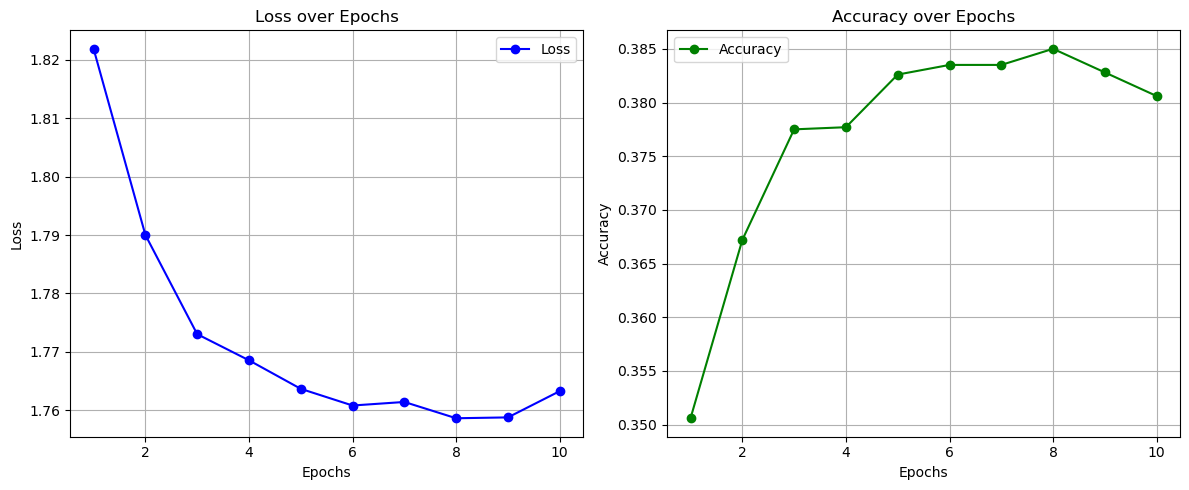

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

epochs = range(1, len(losses) + 1)
# Plot Loss
ax[0].plot(epochs, losses, marker='o', color='b', label='Loss', linestyle='-')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend()

# Plot Accuracy
ax[1].plot(epochs, accuracies, marker='o', color='g', label='Accuracy', linestyle='-')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].grid(True)
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Optimize with Embeded Data

## Embeded

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_eexwuj9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_eexwuj9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=bcf639e31f3d9af445e45f80d69048bd6dfedc4500288d0ebf85a7e3622ce784
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlury5_y/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import os
import numpy as np
import torch
import clip
from PIL import Image

# Kiểm tra và thiết lập thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Đường dẫn lưu các đặc trưng
extracted_features_dir =  os.path.join(lab_folder, "extracted_features")
os.makedirs(extracted_features_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

train_dir = os.path.join(extracted_features_dir, "train")
test_dir = os.path.join(extracted_features_dir, "test")
os.makedirs(train_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại
os.makedirs(test_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 116MiB/s]


In [ ]:

# Kích thước tập huấn luyện
train_ds = trainset
print("Training set size:", len(train_ds))
save_path = os.path.join(extracted_features_dir, "train_features.npy")
if os.path.exists(save_path):
    train_features = np.load(save_path, allow_pickle=True)
else:
    train_features = None

if train_features is None:
    train_features = [() for _ in range(len(train_ds))]

    # Trích xuất và lưu đặc trưng cho từng ảnh
    with torch.no_grad():
        for idx, (image, class_id) in enumerate(train_ds):
            # Tiền xử lý và mã hóa ảnh
            image_input = preprocess(image).unsqueeze(0).to(device)
            image_features = model.encode_image(image_input).cpu().numpy()


            train_features[idx] = image_features

            # Theo dõi tiến trình
            if idx % 1000 == 0:
                print(f"Processed and saved {idx}/{len(train_ds)} images")

    print("Feature extraction and saving completed.")
    train_features = np.array(train_features)
    np.save(save_path, train_features, allow_pickle=True)

train_features.shape

Training set size: 50000


(50000, 1, 512)

In [ ]:
# Kích thước tập huấn luyện
test_ds = testset
print("Test set size:", len(test_ds))

save_path = os.path.join(extracted_features_dir, "test_features.npy")
if os.path.exists(save_path):
    test_features = np.load(save_path, allow_pickle=True)
else:
    test_features = None

if test_features is None:
    test_features = [() for _ in range(len(test_ds))]

    # Trích xuất và lưu đặc trưng cho từng ảnh
    with torch.no_grad():
        for idx, (image, class_id) in enumerate(test_ds):
            # Tiền xử lý và mã hóa ảnh
            image_input = preprocess(image).unsqueeze(0).to(device)
            image_features = model.encode_image(image_input).cpu().numpy()


            test_features[idx] = image_features

            # Theo dõi tiến trình
            if idx % 1000 == 0:
                print(f"Processed and saved {idx}/{len(test_ds)} images")

    print("Feature extraction and saving completed.")
    test_features = np.array(test_features)
    np.save(save_path, test_features, allow_pickle=True)

test_features.shape

Test set size: 10000
Processed and saved 0/10000 images
Processed and saved 1000/10000 images
Processed and saved 2000/10000 images
Processed and saved 3000/10000 images
Processed and saved 4000/10000 images
Processed and saved 5000/10000 images
Processed and saved 6000/10000 images
Processed and saved 7000/10000 images
Processed and saved 8000/10000 images
Processed and saved 9000/10000 images
Feature extraction and saving completed.


(10000, 1, 512)

## Training 1 Model

In [21]:
images, labels = zip(*trainset)
labels = np.array(labels)

train_features = np.load(os.path.join(extracted_features_dir, "train_features.npy"), allow_pickle=True)
trainFeatureSet = torch.utils.data.TensorDataset(torch.tensor(train_features, dtype=torch.float32), torch.tensor(labels))
trainLoader, validLoader = prepare_data(trainFeatureSet)


test_features = np.load(os.path.join(extracted_features_dir, "test_features.npy"), allow_pickle=True)
testFeatureSet = torch.utils.data.TensorDataset(torch.tensor(test_features, dtype=torch.float32), torch.tensor(testset.targets))
testLoader = DataLoader(testFeatureSet, batch_size=batch_size)

inputModelSize = train_features[0].shape[1]
outputModelSize = 10
modelFeature = CIFAR10(inputModelSize, outputModelSize)

learningRate = 0.001
epochs = 100
opt = torch.optim.SGD(modelFeature.parameters(), lr=learningRate)
metric = accuracy

fit(epochs, modelFeature, lossFn, opt, trainLoader, validLoader, metric=metric)

Epoch [1/100], Loss: 1.3038, accuracy: 0.9006
Epoch [2/100], Loss: 0.8668, accuracy: 0.9133
Epoch [3/100], Loss: 0.6655, accuracy: 0.9163
Epoch [4/100], Loss: 0.5534, accuracy: 0.9217
Epoch [5/100], Loss: 0.4842, accuracy: 0.9221
Epoch [6/100], Loss: 0.4363, accuracy: 0.9243
Epoch [7/100], Loss: 0.4012, accuracy: 0.9251
Epoch [8/100], Loss: 0.3753, accuracy: 0.9255
Epoch [9/100], Loss: 0.3546, accuracy: 0.9291
Epoch [10/100], Loss: 0.3381, accuracy: 0.9279
Epoch [11/100], Loss: 0.3238, accuracy: 0.9307
Epoch [12/100], Loss: 0.3121, accuracy: 0.9311
Epoch [13/100], Loss: 0.3018, accuracy: 0.9317
Epoch [14/100], Loss: 0.2927, accuracy: 0.9313
Epoch [15/100], Loss: 0.2855, accuracy: 0.9341
Epoch [16/100], Loss: 0.2787, accuracy: 0.9335
Epoch [17/100], Loss: 0.2729, accuracy: 0.9333
Epoch [18/100], Loss: 0.2677, accuracy: 0.9335
Epoch [19/100], Loss: 0.2625, accuracy: 0.9337
Epoch [20/100], Loss: 0.2581, accuracy: 0.9347
Epoch [21/100], Loss: 0.2538, accuracy: 0.9345
Epoch [22/100], Loss: 

[0.1,
 0.9006410256410257,
 0.913261217948718,
 0.9162660256410257,
 0.9216746794871795,
 0.9220753205128205,
 0.9242788461538461,
 0.9250801282051282,
 0.9254807692307693,
 0.9290865384615384,
 0.9278846153846154,
 0.9306891025641025,
 0.9310897435897436,
 0.9316907051282052,
 0.9312900641025641,
 0.9340945512820513,
 0.9334935897435898,
 0.9332932692307693,
 0.9334935897435898,
 0.9336939102564102,
 0.9346955128205128,
 0.9344951923076923,
 0.9356971153846154,
 0.9356971153846154,
 0.9350961538461539,
 0.9348958333333334,
 0.9370993589743589,
 0.9360977564102564,
 0.9379006410256411,
 0.9379006410256411,
 0.9375,
 0.9377003205128205,
 0.938301282051282,
 0.938301282051282,
 0.9381009615384616,
 0.9389022435897436,
 0.9391025641025641,
 0.9387019230769231,
 0.9389022435897436,
 0.9399038461538461,
 0.9407051282051282,
 0.9407051282051282,
 0.9403044871794872,
 0.9399038461538461,
 0.9403044871794872,
 0.9405048076923077,
 0.9409054487179487,
 0.9407051282051282,
 0.9401041666666666,
 

Test Evaluate, Loss: 0.19086734471321107, accuracy: 0.9397
Test set with Embeded accuracy: 0.940


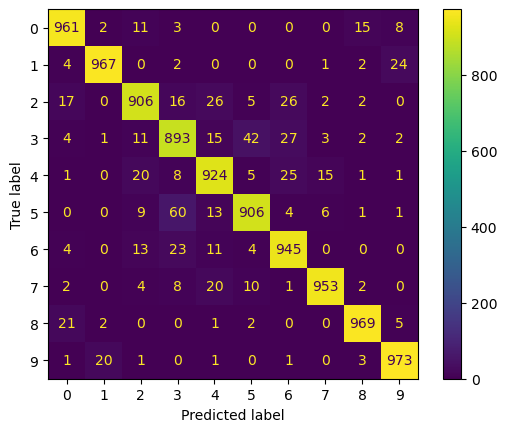

In [22]:
loss, _, acc = evaluate(modelFeature, lossFn, testLoader, metric=accuracy)
print(f"Test Evaluate, Loss: {loss}, accuracy: {acc}")

testsetFeature = [(test_features[idx], label) for idx, (img, label) in enumerate(testset)]
evaluate_with_dataset(modelFeature, testsetFeature, "Test set with Embeded")

## Federate Learning

In [46]:
dataSplitting = DataSplitting(data_folder, os.path.join(data_folder, 'data_split.json'), os.path.join(data_folder, 'data_split_report.json'))
train_features = dataSplitting.load_data_extract_file(os.path.join(extracted_features_dir, "train_features.npy"))
client_names = dataSplitting.get_clients_names()

Files already downloaded and verified
Data split configuration:
Client 1: client_1 - [0, 1, 2, 3, 4]
Client 2: client_2 - [1, 2, 3, 4, 5, 6, 7, 8, 9]
Client 3: client_3 - [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Report loaded successfully from ./data/data_split_report.json
Load training data features from ./extracted_features/train_features.npy


In [47]:
clients = {}
for client_name in client_names:
    clients[client_name] = dataSplitting.get_client_data_extraction(client_name)
    print(f"Client {client_name} has {len(clients[client_name])} data points with shape {clients[client_name][0][0].shape}")

Loading data extraction for client: client_1
Client client_1 has 12663 data points with shape (1, 512)
Loading data extraction for client: client_2
Client client_2 has 22543 data points with shape (1, 512)
Loading data extraction for client: client_3
Client client_3 has 24919 data points with shape (1, 512)


In [48]:
test_features = np.load(os.path.join(extracted_features_dir, "test_features.npy"), allow_pickle=True)
testFeatureSet = torch.utils.data.TensorDataset(torch.tensor(test_features, dtype=torch.float32), torch.tensor(testset.targets))
testFeatureLoader = DataLoader(testFeatureSet, batch_size=batch_size)

global_config = {
    'inputShape': train_features[0].shape[1],
    'outputShape': 10,
    'state_dict': None
}

comms_round = 20
global_model_Feature = CIFAR10(global_config['inputShape'], global_config['outputShape'])

In [49]:
best_loss = float('inf')
best_model_state = global_model.state_dict()
patience = 0  # Number of rounds to wait for an improvement in accuracy
max_patience = 2  # Set the maximum number of rounds for early stopping

# Lists to save data for reporting
losses = []
accuracies = []

for comm_round in range(comms_round):
    print(f"---Starting round {comm_round}---")
    global_state_dict = global_model_Feature.state_dict()
    global_config['state_dict'] = global_state_dict
    client_results = {}

    for client_name in clients_name:
        print(f"\tTraining {client_name}")
        client_data = clients[client_name]
        state_dict, dataLen = train_local_model(client_data, global_config)
        client_results[client_name] = (state_dict, dataLen)
        print(f"Client {client_name} has trained their model with {dataLen} data points.")

    aggregated_state_dict = federated_averaging(client_results)
    global_model_Feature.load_state_dict(aggregated_state_dict)
    print(f"Round {comm_round} has completed.")

    # Evaluate the global model
    loss, _, acc = evaluate(global_model_Feature, lossFn, testFeatureLoader, metric=accuracy)
    losses.append(loss)
    accuracies.append(acc)
    print(f"Test loss: {loss}, Test accuracy: {acc}")

    # Save the best model based on the lowest loss
    if loss < best_loss:
        best_loss = loss
        best_model_state = global_model_Feature.state_dict()
        patience = 0  # Reset patience if we find a new best model
        print(f"New best model found with loss: {best_loss}")
    else:
        patience += 1  # Increment patience if no improvement

    # Early stopping if accuracy does not increase
    if patience >= max_patience:
        print("Early stopping: no improvement in accuracy.")
        break

# Save the best model state after training
global_model_Feature.load_state_dict(best_model_state)
global_model_Feature.save(os.path.join(model_folder, f'global_model_Embeded_lost_{best_loss}.pth'))
print(f"Model saved with loss: {best_loss}")
print("Training completed.")

---Starting round 0---
	Training client_1
Epoch [1/10], Loss: 1.1613, accuracy: 0.9030
Epoch [2/10], Loss: 0.8395, accuracy: 0.9287
Epoch [3/10], Loss: 0.6605, accuracy: 0.9335
Epoch [4/10], Loss: 0.5515, accuracy: 0.9367
Epoch [5/10], Loss: 0.4786, accuracy: 0.9399
Epoch [6/10], Loss: 0.4264, accuracy: 0.9407
Epoch [7/10], Loss: 0.3888, accuracy: 0.9415
Epoch [8/10], Loss: 0.3558, accuracy: 0.9439
Epoch [9/10], Loss: 0.3339, accuracy: 0.9415
Epoch [10/10], Loss: 0.3139, accuracy: 0.9407
Client client_1 has trained their model with 12663 data points.
	Training client_2
Epoch [1/10], Loss: 1.5756, accuracy: 0.8469
Epoch [2/10], Loss: 1.1859, accuracy: 0.9179
Epoch [3/10], Loss: 0.9454, accuracy: 0.9196
Epoch [4/10], Loss: 0.7891, accuracy: 0.9259
Epoch [5/10], Loss: 0.6846, accuracy: 0.9228
Epoch [6/10], Loss: 0.6080, accuracy: 0.9250
Epoch [7/10], Loss: 0.5518, accuracy: 0.9272
Epoch [8/10], Loss: 0.5083, accuracy: 0.9277
Epoch [9/10], Loss: 0.4723, accuracy: 0.9272
Epoch [10/10], Loss

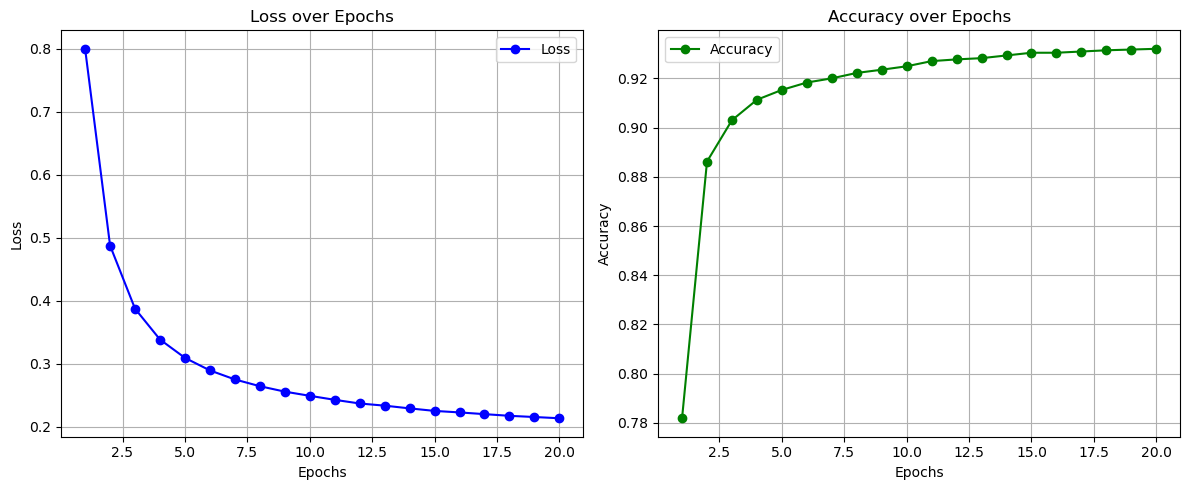

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

epochs = range(1, len(losses) + 1)
# Plot Loss
ax[0].plot(epochs, losses, marker='o', color='b', label='Loss', linestyle='-')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend()

# Plot Accuracy
ax[1].plot(epochs, accuracies, marker='o', color='g', label='Accuracy', linestyle='-')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].grid(True)
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()